# ARIMA and Rolling Forecast



In [94]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## 데이터 읽기와 포매팅

데이터는 3년치 월별 샴푸 판매량으로 [Data Market](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line) 에서 다운로드 받아 저장한 CSV 파일을 사용합니다.

In [95]:
# Month 칼럼을 읽기 위한 파서
def dateparser(x):
    return datetime.strptime('190'+x, "%Y-%m")
#    "1-01" => "1901-01"

In [96]:
shampoo = \
pd.read_csv('data/sales-of-shampoo.csv', index_col='Month', parse_dates=True, \
            date_parser=dateparser)

In [97]:
shampoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1901-01-01 to 1903-12-01
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales of shampoo  36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes


In [98]:
shampoo.tail(2)

,Sales of shampoo
Month,
1903-11-01,581.3
1903-12-01,646.9


## Visualize the data

pandas 내장 플로팅 함수들로 시계열 데이터를 시각화 해봅니다. 뚜렷한 트랜드를 보이는 반면 시즌 패턴은 보이지 않습니다.

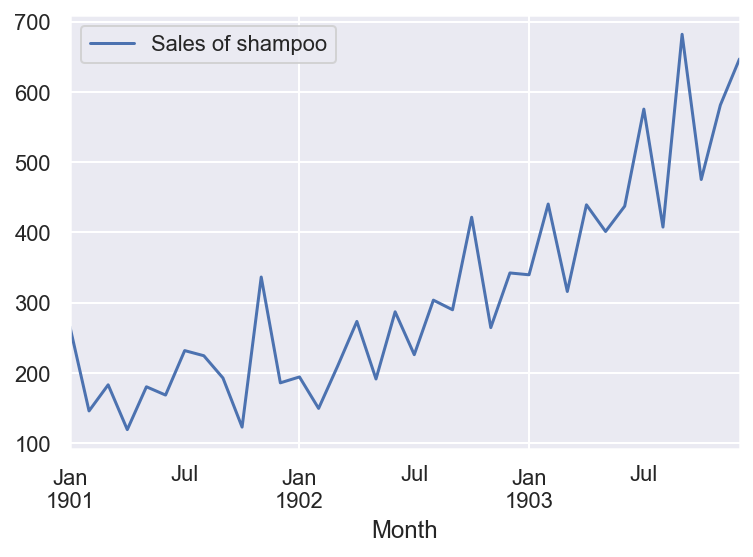

In [99]:
shampoo.plot()

## Testing for Stationarity

In [100]:
from statsmodels.tsa.stattools import adfuller

In [101]:
def adf_check(ts):
    result = adfuller(ts)
    if result[1] < 0.05:
        print('Stationary {}'.format(result[1]))
    else:
        print('Non-Stationary {}'.format(result[1]))

In [102]:
adf_check(shampoo['Sales of shampoo'])

Non-Stationary 1.0


테스트 결과 데이터가 stationary 특성을 보이지 않고 있음이 확인됩니다.

## Differencing

시계열 데이터에 대한 1차(first) difference 는 다음 스탭으로의 한 차원(시간단위) 만큼의 변화값의 series 입니다. pandas 를 이용하면 아주 differencing 할 수 있습니다. 1차, 2차 등 differencing 을 시도해보고 stationary 한 차원을 찾습니다.

#### First Difference

In [103]:
shampoo['1st diff'] = shampoo['Sales of shampoo'] - shampoo['Sales of shampoo'].shift(1)

In [104]:
adf_check(shampoo['1st diff'].dropna())

Stationary 1.7998574141687034e-10


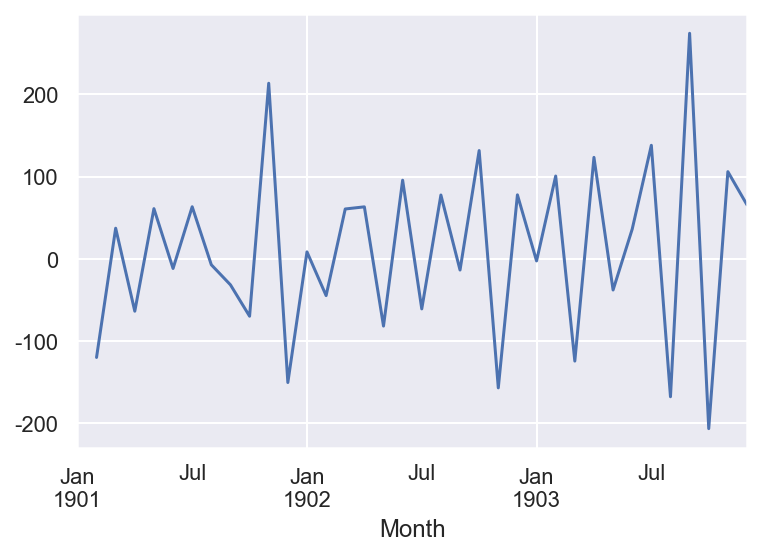

In [105]:
shampoo['1st diff'].plot()
plt.show()

#### Second Difference

In [106]:
shampoo['2nd diff'] = shampoo['1st diff'] - shampoo['1st diff'].shift()

In [107]:
adf_check(shampoo['2nd diff'].dropna())

Stationary 0.0039063349396599245


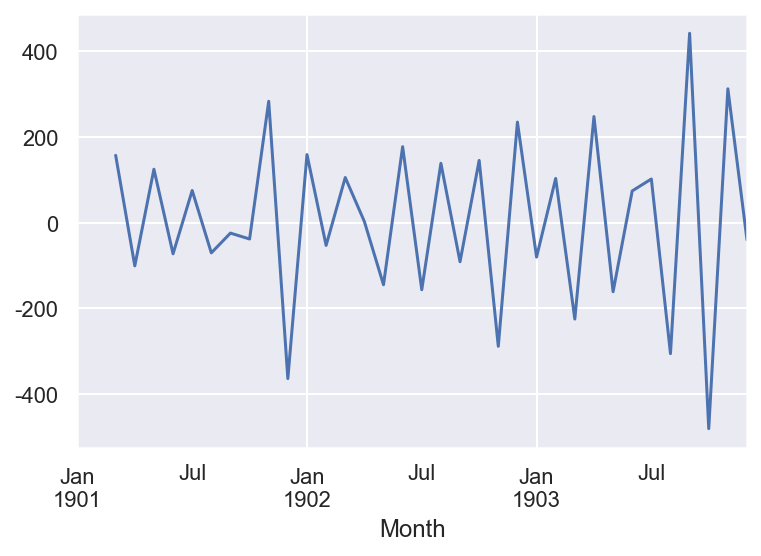

In [108]:
shampoo['2nd diff'].plot()

## Autocorrelation and Partial Autocorrelation Plots

In [109]:
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

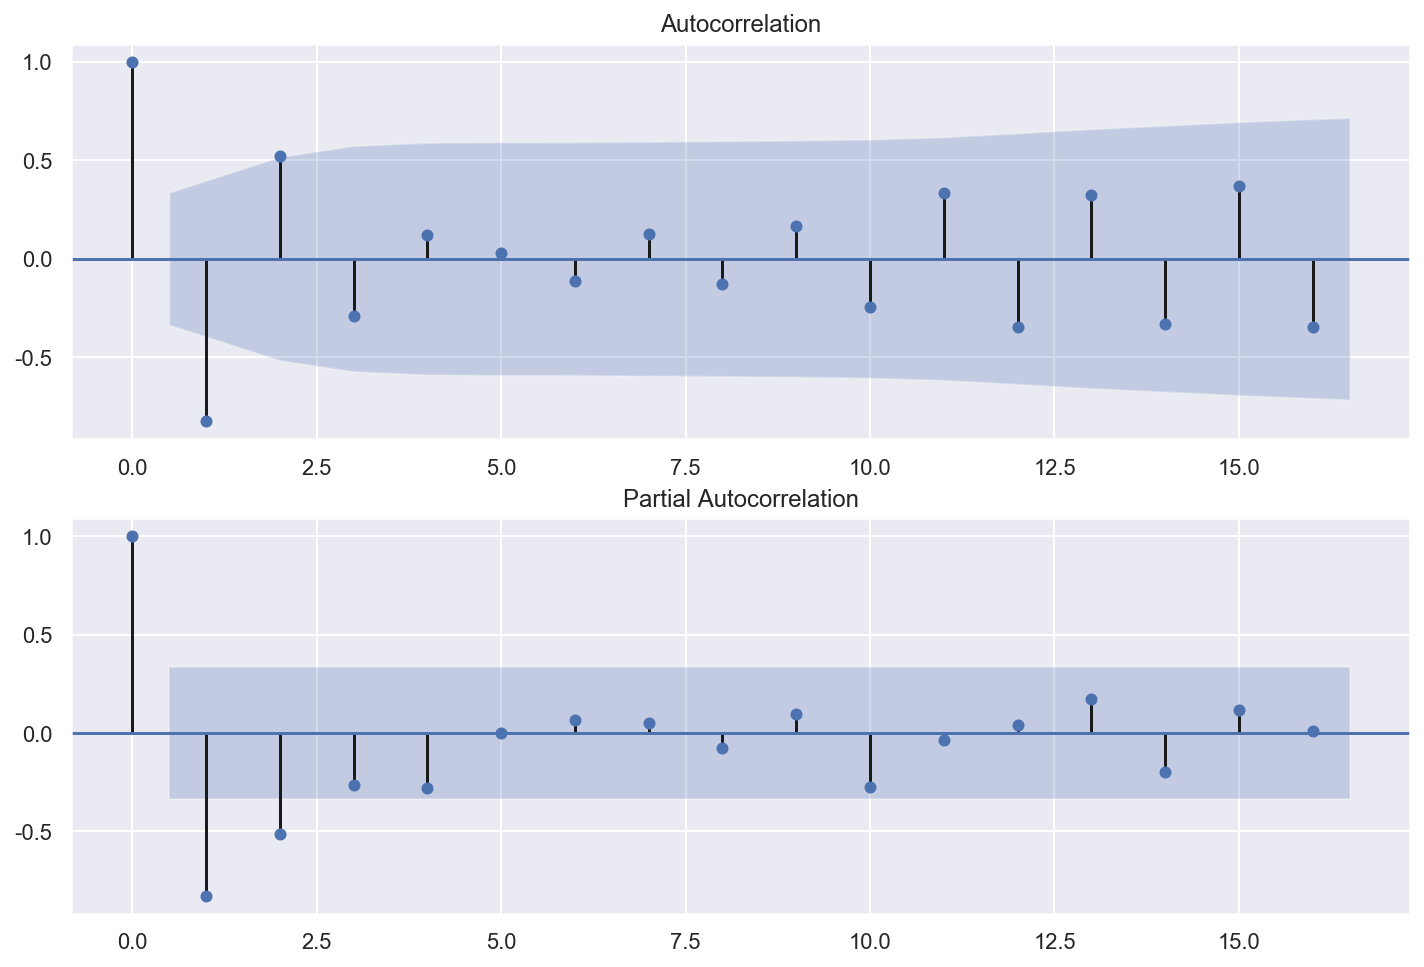

In [110]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(shampoo['2nd diff'].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(shampoo['2nd diff'].dropna(), ax=ax2, method='ywm')

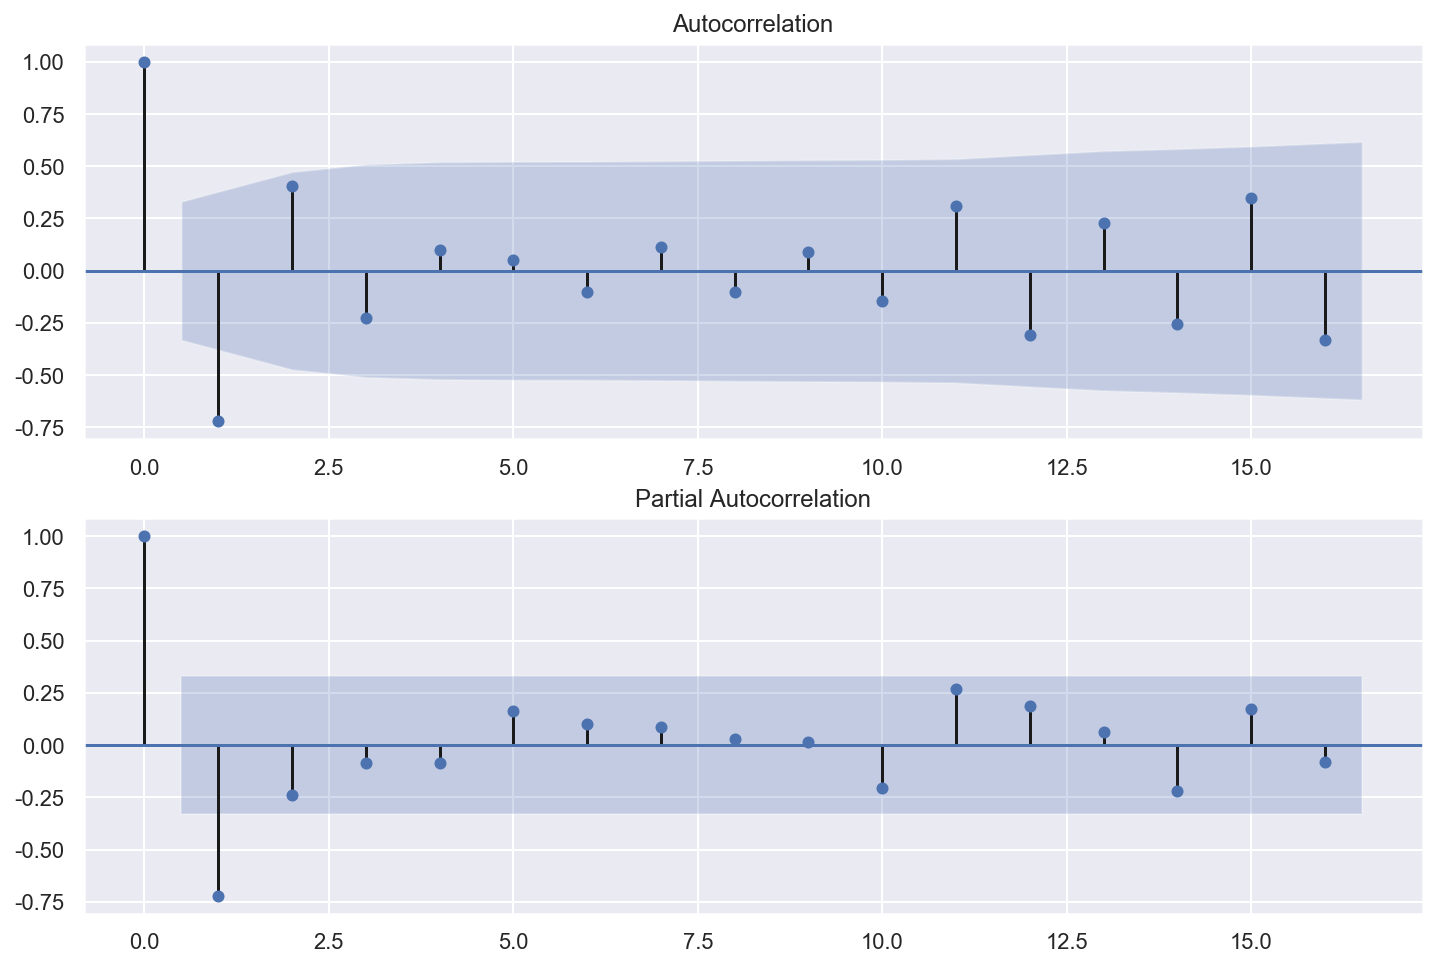

In [111]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(shampoo['1st diff'].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(shampoo['1st diff'].dropna(), ax=ax2, method='ywm')

    PACF 와 ACF 에서 각각 lag 1 에 대해 강한 상관관계를 보이고 있습니다.

#### GridSearch
    AIC 를 기준으로 최적의 p,d,q 파라메터를 찾습니다.

In [28]:
from statsmodels.tsa.arima_model import ARIMA

In [169]:
p = list(range(0,5))
d = [1,2]
q = [0]

In [170]:
import itertools

pdq = list(itertools.product(p,d,q))
pdq

[(0, 1, 0),
 (0, 2, 0),
 (1, 1, 0),
 (1, 2, 0),
 (2, 1, 0),
 (2, 2, 0),
 (3, 1, 0),
 (3, 2, 0),
 (4, 1, 0),
 (4, 2, 0)]

In [171]:
for param in pdq:
    model = ARIMA(shampoo['Sales of shampoo'], order=param)
    result = model.fit()
    print('ARIMA{} - AIC:{}'.format(param, result.aic))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaco

ARIMA(0, 1, 0) - AIC:430.87311187552797
ARIMA(0, 2, 0) - AIC:461.1578257086931
ARIMA(1, 1, 0) - AIC:406.02228959235015
ARIMA(1, 2, 0) - AIC:423.90008603782104
ARIMA(2, 1, 0) - AIC:403.62756411659745
ARIMA(2, 2, 0) - AIC:412.9993824970764
ARIMA(3, 1, 0) - AIC:404.69245918171157
ARIMA(3, 2, 0) - AIC:410.9109265845824


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 0) - AIC:404.7867685566948
ARIMA(4, 2, 0) - AIC:403.9482289506923


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


#### Rolling Forecast ARIMA Model

    ARIMA 모델로 미래 데이터를 예측하기 위해 predict() 함수를 사용합니다. 이 함수는 파라메터로 예측할 타임스텝을(steps) 필요로하는데 학습 데이터에 대한 인덱스 상대값을 입력하면 됩니다. 가령 모델을 학습하기 위해 100개의 학습데이터를 사용했다면 다음 스텝 예측값의 인덱스는 start=101, end=101 이 됩니다. 예측 결과 리턴값은 하나의 예측값을 포함한 배열이 됩니다.

    또는 forcast() 함수로 파라메터 없이 다음 한 스템의 데이터를 예측할 수 있습니다. 

    데이터를 train 과 test 로 나눈 뒤 train 데이터로 모델을 학습시키고 test 데이터의 각 시점에 해당하는 값을 예측 해봅니다. 그러기 위해 새로운 actual value 를 하나씩 수집하면서 그와 함께 앞선 시점의 데이터로 ARIMA 모델을 학습과 예측을 반복하는 rolling forecast 를 수행하게 됩니다.

    아래 코드에서 수동으로 관측값을을 history 변수에 추가해가면서 모델링과 예측을 반복하면서 prediction 과 expected value 를 출력하고 최종적으로 그에 따른 mean squared error (MSE) 를 계산합니다.

In [239]:
shampoo.tail(2)

,Sales of shampoo,1st diff,2nd diff
Month,,,
1903-11-01,581.3,106.0,312.7
1903-12-01,646.9,65.6,-40.4


In [222]:
from sklearn.metrics import mean_squared_error
from math import sqrt

p,d,q = 2,1,0
X = shampoo['Sales of shampoo'].values

size = int(len(X)*0.67)
train, test = X[:size], X[size:]

history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(p,d,q))
    result = model.fit(disp=0)
    output = result.forecast()
    y_hat = output[0]
    predictions.append(y_hat)
    obs = test[t]
    history.append(obs)
    print('predicted:%f, expected:%f' % (y_hat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % sqrt(error))

predicted:316.888890, expected:339.700000
predicted:337.349530, expected:440.400000
predicted:378.283353, expected:315.900000
predicted:413.321133, expected:439.300000
predicted:370.978125, expected:401.300000
predicted:425.757106, expected:437.400000
predicted:429.401329, expected:575.500000
predicted:474.580676, expected:407.600000
predicted:542.710089, expected:682.000000
predicted:480.813554, expected:475.300000
predicted:634.327360, expected:581.300000
predicted:561.051469, expected:646.900000
Test RMSE: 77.571


In [223]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   34
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -192.019
Method:                       css-mle   S.D. of innovations             67.578
Date:                Wed, 02 Sep 2020   AIC                            392.038
Time:                        13:02:47   BIC                            398.143
Sample:                             1   HQIC                           394.120
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5699      5.220      2.025      0.043       0.338      20.801
ar.L1.D.y     -0.9837      0.171     -5.764      0.000      -1.318      -0.649
ar.L2.D.y     -0.2902      0.180     -1.615      0.1

In [224]:
# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(test, predictions)
# rmse = np.sqrt(mse)
# rmse # root mse (error)

In [232]:
# shampoo['Sales of shampoo'].describe()

다음으로 residual error 에 대한 density plot 을 그리고 정규분포에 가까운지 확인합니다.

In [231]:
# result.resid.plot(kind='kde')

In [187]:
# result.resid.describe()

실제값(파란색)과 rolling forecast(red) 결과를 비교해보면 트렌드를 어느정도 예측하고 있음을 확인할 수 있습니다.

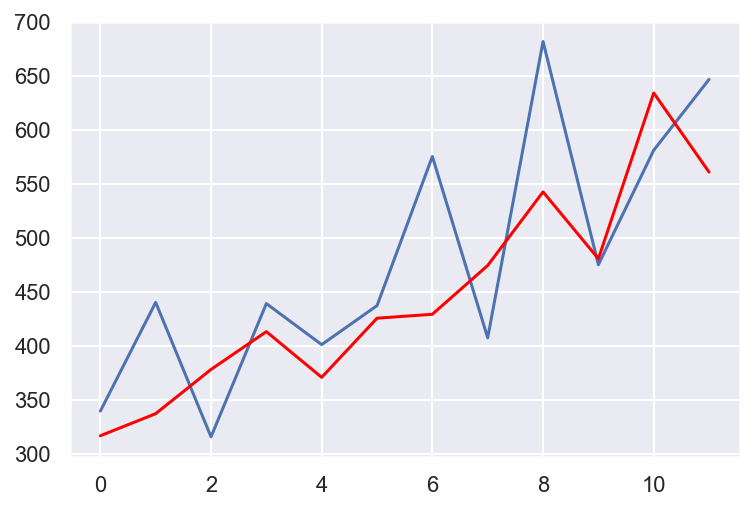

In [233]:
plt.plot(test)
plt.plot(predictions, color='red')